## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings to keep notebook clean
import random
from sklearn.model_selection import train_test_split

## Collect the data

In [2]:
root_dir = '..'
data_dir = os.path.join(root_dir, 'data')
images_dir = os.path.join(data_dir, 'Orignal-Dataset')
root_dir, data_dir, images_dir

('..', '..\\data', '..\\data\\Orignal-Dataset')

In [3]:
# Function to load all images from a folder

def load_images_from_folder(folder_path, resize=None):
    """
    Load all images from a folder
    
    Args:
        folder_path: path to the folder
        resize: tuple (width, height) to resize images, None to skip resizing
    
    Returns:
        list: list of tuples (image, filename)
    """
    images = []
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist")
        return images
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            filepath = os.path.join(folder_path, filename)
            try:
                # Use PIL to load image and convert to numpy array (BGR format for OpenCV compatibility)
                img = Image.open(filepath).convert('RGB')
                img_array = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
                
                if resize:
                    img_array = cv2.resize(img_array, resize)
                images.append((img_array, filename))
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    
    return images

# Load images from Orignal-Dataset with resize to 224x224
soil_types = ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 
              'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']

images_dict = {}
for soil_type in soil_types:
    folder_path = os.path.join(data_dir, 'Orignal-Dataset', soil_type)
    images_dict[soil_type] = load_images_from_folder(folder_path, resize=(224, 224))
    print(f"{soil_type}: {len(images_dict[soil_type])} images loaded")

Alluvial_Soil: 51 images loaded
Arid_Soil: 284 images loaded
Black_Soil: 255 images loaded
Laterite_Soil: 219 images loaded
Mountain_Soil: 201 images loaded
Red_Soil: 109 images loaded
Yellow_Soil: 69 images loaded


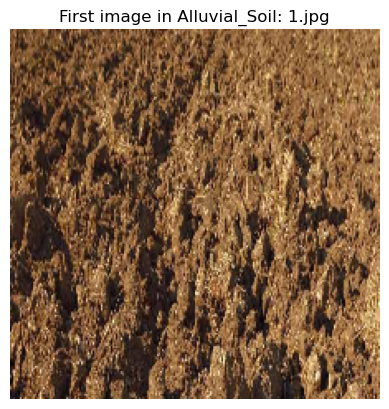

In [4]:
# Display the first image 

first_soil_type = soil_types[0]
if images_dict[first_soil_type]:
    first_image, first_filename = images_dict[first_soil_type][0]
    plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
    plt.title(f"First image in {first_soil_type}: {first_filename}")
    plt.axis('off')
    plt.show()

## Pre-process the data

In [5]:
# Standardize the data

def standardize_image(image):
    """
    Standardize an image to have zero mean and unit variance per channel.
    
    Args:
        image: numpy array of shape (H, W, C)

    Returns:
        standardized_image: numpy array of same shape as input
    """
    standardized_image = np.zeros_like(image, dtype=np.float32)
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        mean = np.mean(channel)
        std = np.std(channel)
        if std > 0:
            standardized_image[:, :, c] = (channel - mean) / std
        else:
            standardized_image[:, :, c] = channel - mean  # Avoid division by zero
    return standardized_image

# Standardize all images in the dataset
standardized_images_dict = {}
for soil_type, images in images_dict.items():
    standardized_images = []
    for img, filename in images:
        standardized_img = standardize_image(img)
        standardized_images.append((standardized_img, filename))
    standardized_images_dict[soil_type] = standardized_images

## Build the GAN model

In [6]:
# Generator

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape): # img_shape is a tuple (C, H, W)
        super(Generator, self).__init__() # Initialize the Generator class
        self.latent_dim = latent_dim  # Dimensionality of the latent space
        self.img_shape = img_shape    # Shape of the output image
        
        def block(in_feat, out_feat, normalize=True):   # Define a block of layers
            layers = [nn.Linear(in_feat, out_feat)]  # Linear layer
            if normalize:   # Add batch normalization if specified
                layers.append(nn.BatchNorm1d(out_feat, 0.8))   # Batch normalization layer
            layers.append(nn.LeakyReLU(0.2, inplace=True))     # LeakyReLU activation
            return layers   # Return the list of layers
        
        self.model = nn.Sequential(   # Define the model as a sequence of layers
            *block(latent_dim, 128, normalize=False),  # First block without normalization
            *block(128, 256),  # Second block
            *block(256, 512),  # Third block
            *block(512, 1024), # Fourth block
            nn.Linear(1024, int(np.prod(img_shape))),  # Final linear layer to match image size
            nn.Tanh()  # Tanh activation to output values in [-1, 1]
        )
    
    def forward(self, z):   # Define the forward pass
        img = self.model(z)  # Pass the input through the model
        img = img.view(img.size(0), *self.img_shape)  # Reshape output to image shape
        return img  # Return the generated image

In [7]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, img_shape):  # img_shape is a tuple (C, H, W)
        super(Discriminator, self).__init__()  # Initialize the Discriminator class
        self.img_shape = img_shape  # Shape of the input image
        
        self.model = nn.Sequential(  # Define the model as a sequence of layers
            nn.Linear(int(np.prod(img_shape)), 512),  # First linear layer
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(512, 256),  # Second linear layer
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(256, 1),  # Final linear layer to output a single value
            nn.Sigmoid()  # Sigmoid activation to output probability in [0, 1]
        )
    
    def forward(self, img):  # Define the forward pass
        img_flat = img.view(img.size(0), -1)  # Flatten the input image
        validity = self.model(img_flat)  # Pass the flattened image through the model
        return validity  # Return the validity score

## Train the GAN model

In [8]:
# General
SEED = 42
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRAIN_RATIO  = 0.7
VAL_RATIO    = 0.1
TEST_RATIO   = 0.2

LEARNING_RATE = 0.01

# Use parameters for seed and device
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device(DEVICE)
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cpu


In [9]:
# Split the dataset using train_test_split

all_images = []
all_labels = []
for soil_type, images in standardized_images_dict.items():
    for img, filename in images:
        all_images.append(img)
        all_labels.append(soil_type)
X_temp, X_test, y_temp, y_test = train_test_split(all_images, all_labels, test_size=TEST_RATIO, random_state=SEED, stratify=all_labels)
relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=relative_val_ratio, random_state=SEED, stratify=y_temp)
print(f"Dataset split into train ({len(X_train)}), val ({len(X_val)}), test ({len(X_test)})")

Dataset split into train (831), val (119), test (238)


In [10]:
# Create a custom Dataset class for PyTorch

class SoilDataset(Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images: list of numpy arrays (images)
            labels: list of labels (soil type strings)
        """
        self.data = images
        self.labels = labels
        
        # Create a mapping from soil type to index
        unique_labels = sorted(list(set(labels)))
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(unique_labels)}
        
        # Convert string labels to indices
        self.label_indices = [self.soil_type_to_idx[label] for label in labels]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Convert image from (H, W, C) to (C, H, W) for PyTorch
        img = self.data[idx]
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        img_tensor = torch.FloatTensor(img)
        label = self.label_indices[idx]
        return img_tensor, label

# Create datasets
train_dataset = SoilDataset(X_train, y_train)
val_dataset = SoilDataset(X_val, y_val)
test_dataset = SoilDataset(X_test, y_test)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders 
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)


Train set size: 831
Validation set size: 119
Test set size: 238


In [11]:
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss()

In [12]:
# Instantiate the models
latent_dim = 100  # Dimension of the latent space
img_shape = (3, 224, 224)  # Shape of images (C, H, W) - adjust according to your standardized images

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Select Adam optimizer for both generator and discriminator
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
# Training loop with optimizations

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Move data to device
        imgs = imgs.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_discriminator.zero_grad()

        # Real images
        real_loss = loss_function(discriminator(imgs), valid)

        # Fake images
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        fake_loss = loss_function(discriminator(gen_imgs.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_discriminator.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_generator.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z)
        g_loss = loss_function(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_generator.step()

    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


[Epoch 0/50] [D loss: 1.1934316158294678] [G loss: 0.05357401818037033]
[Epoch 1/50] [D loss: 0.15465784072875977] [G loss: 2.0336756706237793]
[Epoch 2/50] [D loss: 1.083282232284546] [G loss: 0.7373196482658386]
[Epoch 3/50] [D loss: 0.07425780594348907] [G loss: 3.1285126209259033]
[Epoch 4/50] [D loss: 0.3765694200992584] [G loss: 4.621074199676514]
[Epoch 5/50] [D loss: 0.13431373238563538] [G loss: 7.631572246551514]
[Epoch 6/50] [D loss: 0.38103199005126953] [G loss: 13.535309791564941]
[Epoch 7/50] [D loss: 0.489865243434906] [G loss: 26.419837951660156]
[Epoch 8/50] [D loss: 1.891725778579712] [G loss: 15.342020034790039]
[Epoch 9/50] [D loss: 0.2746487557888031] [G loss: 80.9426498413086]
[Epoch 10/50] [D loss: 0.5106235146522522] [G loss: 96.76697540283203]
[Epoch 11/50] [D loss: 8.704220988420275e-08] [G loss: 96.07424926757812]
[Epoch 12/50] [D loss: 6.225242259461083e-07] [G loss: 82.78270721435547]
[Epoch 13/50] [D loss: 19.26932144165039] [G loss: 91.7846908569336]
[Epo

## Evaluate the model on the test set

In [14]:
# Classify all the images in the test set using the trained discriminator

# Move discriminator to device
discriminator = discriminator.to(device)
discriminator.eval()
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)
all_predictions = []
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = discriminator(imgs)
        predictions = (outputs > 0.5).long()  # Threshold at 0.5
        all_predictions.extend(predictions.cpu().numpy())
print(f"Classified {len(all_predictions)} images in the test set.")

Classified 238 images in the test set.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6034468..3.882238].


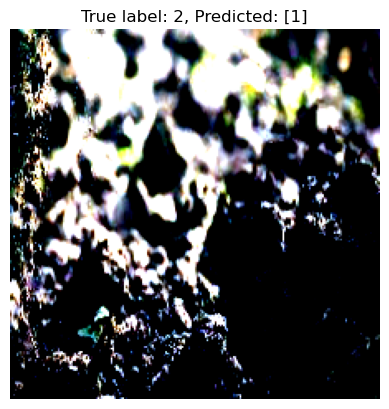

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.060328..7.0810165].


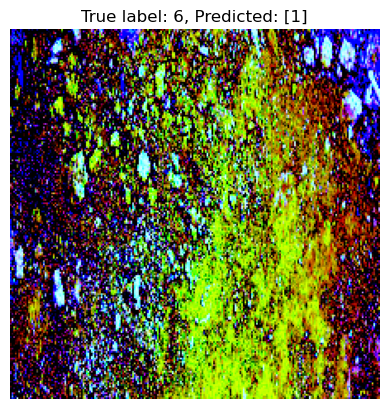

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7705662..2.9085572].


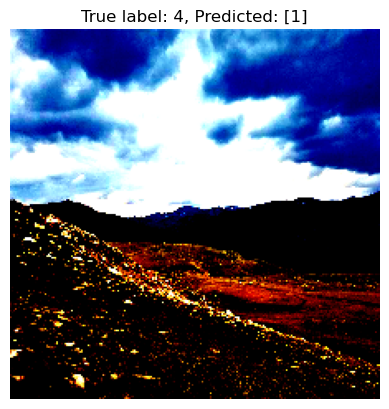

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.188525..3.3109097].


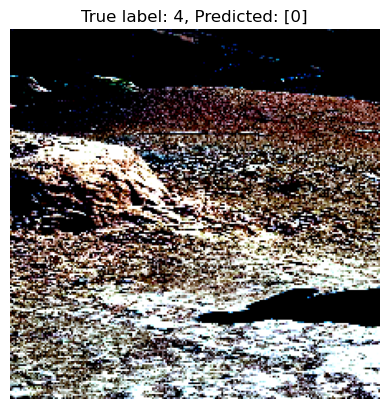

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2054508..2.8674593].


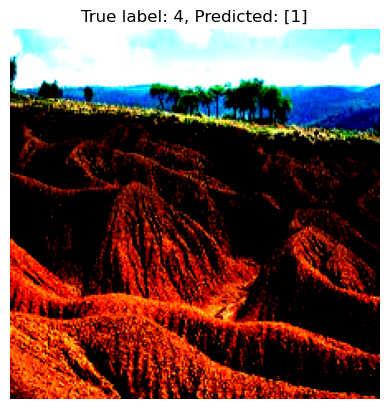

In [15]:
# Verify the classifications

for i in range(5):
    img, label = test_dataset[i]
    img_np = img.numpy().transpose(1, 2, 0)  # Convert back to (H, W, C) for display
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.title(f"True label: {label}, Predicted: {all_predictions[i]}")
    plt.axis('off')
    plt.show()